# 0.0 Business Context

## 0.1 Business Problem

Our challenge is to help the **Cardio Catch Diseases** a company that specializes in detecting heart diseases in the early stages. 

Its Business model is 'service' it means that the company offers an early heart disease diagnostic for a price.

Important Details:

- Actually, the precision of the diagnostic is between 55% and 65%.
- For each 5% of accuracy over 50% the price is R$ 500,00

**Main Goal:**

Create a tool that increases diagnostic accuracy and that this accuracy is stable for all diagnostics.

**Secondary Goals:**

Answer the CEO questions,

1. What is the Accuracy and Precision of the tool?
2. How much profit will Cardio Catch Diseases have with the new tool?
3. How Reliable is the result given by the new tool?


Business problem reference: https://sejaumdatascientist.com/projeto-de-data-science-diagnostico-precoce-de-doencas-cardiovasculares/

Download the data: https://www.kaggle.com/sulianova/cardiovascular-disease-dataset


**Index:**

0.2 - Helper Functions and Imports

1.0 - Collect Data

2.0 - Data Description

3.0 - Splitting data

4.0 - EDA

5.0 - Hypothesis Test

6.0 - Pre-Processing / Feature Engineering

7.0 - Machine Learning Modelling

8.0 - API

## 0.2 Conclusions and Results

After all procedures and analyses performed the best result was with LGBM Model.

**LGBM: with a threshold of 0.4**
 - Recall of 0.78
 - Accuracy of 0.73

What answers the first question of the CEO.

About the profit, the price was increased by 4.4 times reaching R$ 2219.0

**Why focus on recall than precision(preferred metric of the business)?**

Because of the nature of the problem, heart diseases, a false diagnosis to an actual sick patient could lead to aggravation of the problem or even death. Bussines wise, it could hurt us as a future legal process. Focusing on recall we make less money but we get away less risk of the legal process.


**Scenario focusing on precision**

 - Precision = 0.80
 - Accuracy = 0.75
 - Recall = 0.67
 
Price increased by 4.63 times reaching R$ 2316.0

# 0.2 Helper Functions and Imports

## 0.2.1 Imports

In [38]:
# General Propose
import shap
import pickle
shap.initjs()
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scikitplot import metrics as mt

# Hipo Test
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import ttest_ind


# Pre-processing
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder

# Modelling
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans


# Evaluation
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, precision_score, f1_score, recall_score
from yellowbrick.classifier.threshold import discrimination_threshold

# Set options and warnings
import warnings
warnings.filterwarnings('ignore')
pd.set_option('MAX_ROWS', None)

## 0.2.2 Helper Functions

In [14]:
# Helper Functions
def balanced_target(target, dataset, hue=None):
    """
    Function to check the balancing of the target variable.

    :target:  An pd.Series of the target variable that will be checked.
    :dataset: An Dataframe object. 
    """
    sns.set(style='darkgrid', palette='Accent')
    ax = sns.countplot(x=target, hue=hue, data=dataset)
    ax.figure.set_size_inches(10, 6)
    ax.set_title('Cardio Distribution', fontsize=18, loc='left')
    ax.set_xlabel(target, fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax=ax


def univariate_analysis(target, df):
    """
    Function to perform univariate analysis.

    df: DataFrame
    """
    for col in df.columns.to_list():

        fig = sns.displot(x=col, hue=target, data=df, kind='hist')
        fig.set_titles(f'{col}\n distribuition', fontsize=16)
        fig.set_axis_labels(col, fontsize=14)


def multi_histogram(data: pd.DataFrame, variables: list) -> None:

    # set of initial plot posistion
    plt.figure(figsize=(18, 10))
    n = 1
    for column in data[variables].columns:
        plt.subplot(3, 3, n)
        _ = sns.histplot(x=data[column], bins=50)
        n += 1

    plt.subplots_adjust(hspace=0.3)

    plt.show()



def multi_boxplot(data: pd.DataFrame, variables: list) -> None:

    """
    Function to check for outliers visually through a boxplot

    data: DataFrame

    variable: list of numerical variables
    """

    # set of initial plot posistion
    plt.figure(figsize=(18, 10))
    n = 1
    for column in data[variables].columns:
        plt.subplot(3, 3, n)
        _ = sns.boxplot(x=column, data=data)
        n += 1

    plt.subplots_adjust(hspace=0.3)

    plt.show()


def hipo_test(*samples):

    samples = samples

    try:
        if len(samples) == 2:
            stat, p = ttest_ind(*samples)
        elif len(samples) > 2:
            stat, p = f_oneway(*samples)
    except:
        raise Exception("Deve ser fornecido pelo menos duas samples!!!")

    if p < 0.05:
        print(f'O valor de p é: {p}')
        print('Provável haver diferença')
    else:
        print(f'O valor de p é: {p}')
        print('Provável que não haja diferença')

    return stat, p


def point_bi_corr(a, b):

    """
    Function to calculate point biserial correlation coefficient heatmap function
    Credits: Bruno Santos - Comunidade DS

    :a: input dataframe with binary variable
    :b: input dataframe with continous variable
    """

    # Get column name
    a = a.values.reshape(-1)
    b = b.columns.reshape(-1)

    # apply scipys point-biserial
    stats.pointbiserialr(a, b)

    # correlation coefficient array
    c = np.corrcoef(a, b)

    # dataframe for heatmap
    df = pd.DataFrame(c, columns=[a, b], index=[a, b])

    # return heatmap
    return sns.heatmap(df, annot=True).set_title('{} x {} correlation heatmap'.format(a, b));


def change_threshold_lgbm(X, y, model, n_splits, thresh):

    # cross-validação
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

    acc = []
    kappa = []
    recall = []
    for linhas_treino, linhas_valid in skf.split(X, y):

        X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
        y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]

        pred_prob = model.predict_proba(X_valid)

        for i in range(0, len(pred_prob)):
            if pred_prob[i, 1] >= thresh:
                pred_prob[i, 1] = 1
            else:
                pred_prob[i, 1] = 0

        Acc = accuracy_score(y_valid, pred_prob[:, 1])
        Kappa =  cohen_kappa_score(y_valid, pred_prob[:, 1])
        Recall = recall_score(y_valid, pred_prob[:, 1])
        acc.append(Acc)
        kappa.append(Kappa)
        recall.append(Recall)

    print('####### Bussines Metrics #######')
    print('\n')
    acc_inc = np.mean(acc) - 0.50
    prc_inc = round((acc_inc/0.05)*500, 2)
    print(f'Increased precision: {round(acc_inc,2)}')
    print(f'Price Increased in: {prc_inc}')
    print(f'Percentual of Price increassing: {round(prc_inc/500,2)}')
    print('\n')

    # print classification report
    print('####### Machine Learning Metrics #######\n')
    print(classification_report(y_valid, pred_prob[:,1], digits=2))

    # Confusion Matrix
    mt.plot_confusion_matrix(y_valid, pred_prob[:,1], normalize=False, figsize=(10,8))

    return pred_prob[:, 1]


def change_threshold_lr(X, y, model, n_splits, thresh):
    # cross-validação
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

    acc = []
    kappa = []
    recall = []
    for linhas_treino, linhas_valid in skf.split(X, y):

        X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
        y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]

        y_scores_final = model.decision_function(X_valid)
        y_pred_recall = (y_scores_final > thresh)

        Acc = accuracy_score(y_valid, y_pred_recall)
        Kappa =  cohen_kappa_score(y_valid, y_pred_recall)
        Recall = recall_score(y_valid, y_pred_recall)
        acc.append(Acc)
        kappa.append(Kappa)
        recall.append(Recall)

    print('####### Bussines Metrics #######\n')

    acc_inc = np.mean(acc) - 0.50
    prc_inc = round((acc_inc/0.05)*500, 2)
    print(f'Increased precision: {round(acc_inc,2)}')
    print(f'Price Increased in: {prc_inc}')
    print(f'Percentual of Price increassing: {round(prc_inc/500,2)}')
    print('\n')

    print('####### Machine Learning Metrics #######\n')
    print(f'New kappa: {cohen_kappa_score(y_valid,y_pred_recall)}\n')
    print(classification_report(y_valid, y_pred_recall, digits=2))


    return y_pred_recall


################################################# Custons Transformers ###########################################################

class PreProcessingTransformer(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        Xtemp = X.copy()

        # Height
        index_height = Xtemp.loc[Xtemp['height'] > 230, ['height']].index
        Xtemp.drop(index_height, inplace=True)
        index_height1 = Xtemp.loc[Xtemp['height'] < 112, ['height']].index
        Xtemp.drop(index_height1, inplace=True)

        # Weight
        index_weight = Xtemp.loc[Xtemp['weight'] < 40, ['weight']].index
        Xtemp.drop(index_weight, inplace=True)

        # ap_hi
        index_ap_hi = Xtemp.loc[Xtemp['ap_hi'] < 10, ['ap_hi']].index
        Xtemp.drop(index_ap_hi, inplace=True)

        # ap_lo
        index_ap_lo = Xtemp.loc[Xtemp['ap_lo'] < 5, ['ap_lo']].index
        Xtemp.drop(index_ap_lo, inplace=True)

        # SMOTE + TOMEKLINK
        X = Xtemp.drop('cardio', axis=1)
        y = Xtemp['cardio']

        smt = SMOTETomek(random_state=42)
        Xres, yres = smt.fit_resample(X, y)
        Xtemp = pd.concat([Xres, yres], axis=1)

        return Xtemp


class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        Xtemp = X.copy()

        # Cluster based var
        kmeans = KMeans(n_clusters=2, init='k-means++',n_init=20, random_state=0).fit(Xtemp)
        Xtemp['kmeans_cat'] = kmeans.labels_

        # # Cluster GMM
        # gmm = GaussianMixture(n_components=3).fit(Xtemp)
        # Xtemp['gauss_cat'] = gmm.predict(Xtemp)

        # Year_age
        Xtemp['year_age'] = Xtemp['age'] / 365

        # drop 'id' and 'age' 'smoke','alco','gluc', 'ap_lo', 'cholesterol', 'height', 'active', 'weight'
        Xtemp.drop(['id', 'age'], inplace=True, axis=1)

        # IMC
        Xtemp['imc'] = Xtemp['weight']/(Xtemp['height']/100)**2

        # cat_dwarfism
        Xtemp['cat_Dwarfism'] = [1 if value < 145 else 0 for value in Xtemp['height']]

        # ap_hi divide 10
        Xtemp.loc[Xtemp['ap_hi'] > 220, ['ap_hi']] = Xtemp.loc[Xtemp['ap_hi'] > 220, ['ap_hi']]/10

        # ap_lo divide 10
        Xtemp.loc[Xtemp['ap_lo'] > 190, ['ap_lo']] = Xtemp.loc[Xtemp['ap_lo'] > 190, ['ap_lo']]/10

        # ap_hi divide 10
        Xtemp.loc[Xtemp['ap_hi'] > 220, ['ap_hi']] = Xtemp.loc[Xtemp['ap_hi'] > 220,['ap_hi']]/10

        # ap_hi divide 10
        Xtemp.loc[Xtemp['ap_hi'] > 220, ['ap_hi']] = Xtemp.loc[Xtemp['ap_hi'] > 220,['ap_hi']]/10

        # ap_lo divide 10
        Xtemp.loc[Xtemp['ap_lo'] > 190, ['ap_lo']] = Xtemp.loc[Xtemp['ap_lo'] > 190,['ap_lo']]/10

        return Xtemp


class CatBloodPressureTransformer(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        Xtemp = X.copy()

        # cat_bloodpressure
        def cat_bloodpressure(df):

            if df['ap_hi'] < 90 and df['ap_lo'] < 60:
                return 1 #Hipotensão
            elif 90 <= df['ap_hi'] < 140 and 60 <= df['ap_lo'] < 90:
                return 2    # Pré-Hipotensão
            elif 140 <= df['ap_hi'] < 160 and 90 <= df['ap_lo'] < 100:
                return 3  # 'Hipertensão estagio1'
            elif df['ap_hi'] >= 160 and df['ap_lo'] >= 100:
                return 4 # 'Hipertensão estagio2'
            else:
                return 5 # 'no_cat'

        # cat_bloodpressure
        Xtemp['cat_bloodpressure'] = Xtemp.apply(cat_bloodpressure, axis=1)

        return Xtemp


class TotalPressureTransformer(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):

        return self

    def transform(self, X, y=None):

        Xtemp = X.copy()

        # total_preassure
        Xtemp['total_pressure'] = Xtemp['ap_hi'] + Xtemp['ap_lo']

        return Xtemp


class MyRobustScalerTransformer(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        Xtemp = X.copy()

        scaler = RobustScaler()
        Xscaled = scaler.fit_transform(Xtemp)
        Xtemp = pd.DataFrame(Xscaled, columns=Xtemp.columns.to_list())

        return Xtemp

# 1.0 Collect Data

In [4]:
train = pd.read_csv('../data/raw/cardio_train.csv', sep=';')
print(f'The number of columns are {train.shape[1]}')
print(f'The number of rows are {train.shape[0]}')

The number of columns are 13
The number of rows are 70000


# 2.0 Data Description

Takeaways:

- Variable age is in days. Let's divide it by 365 and check if the values make sense.
- We will drop 'id' at some point because doesn't give us much information.
- No need to encoding categorical variables.
- Binary classification problem.
- Let's consider the possibility os OHE the categorical variables to.

In [5]:
# Sneak look
train.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [6]:
# Details of the data
pd.DataFrame({'missingPerc': train.isna().mean(),
              'uniques': train.nunique(),
              '%uniquePerc': round((train.nunique()/train.shape[0])*100, 2),
              'data_types': train.dtypes,
              'mean': round(train.mean(), 2),
              'median': round(train.median(), 2),
              'std': round(train.std(), 2),
              'min': round(train.min(), 2),
              'max': round(train.max(), 2)})

,missingPerc,uniques,%uniquePerc,data_types,mean,median,std,min,max
id,0.0,70000,100.00,int64,49972.42,50001.5,28851.30,0.0,99999.0
age,0.0,8076,11.54,int64,19468.87,19703.0,2467.25,10798.0,23713.0
gender,0.0,2,0.00,int64,1.35,1.0,0.48,1.0,2.0
height,0.0,109,0.16,int64,164.36,165.0,8.21,55.0,250.0
weight,0.0,287,0.41,float64,74.21,72.0,14.40,10.0,200.0
ap_hi,0.0,153,0.22,int64,128.82,120.0,154.01,-150.0,16020.0
ap_lo,0.0,157,0.22,int64,96.63,80.0,188.47,-70.0,11000.0
cholesterol,0.0,3,0.00,int64,1.37,1.0,0.68,1.0,3.0
gluc,0.0,3,0.00,int64,1.23,1.0,0.57,1.0,3.0
smoke,0.0,2,0.00,int64,0.09,0.0,0.28,0.0,1.0


# 3.0 Splitting Data

## 3.1 Split Data

In [5]:
# splitting data
dfTrain = train[:60000]

# Validação
dfValid = train[60000:]
X = dfValid.drop(['cardio'], axis=1)
y = dfValid['cardio']

In [24]:
dfTrain.shape

(60000, 13)

# 4.0 EDA

## 4.1 Univariate Analysis

Main takeaways:

- Our target is balanced with 35000 observations for each class.
- 'age' and 'weight'(as they increase) seems to have more influence over 'cardio'
- We do have outliers!!!

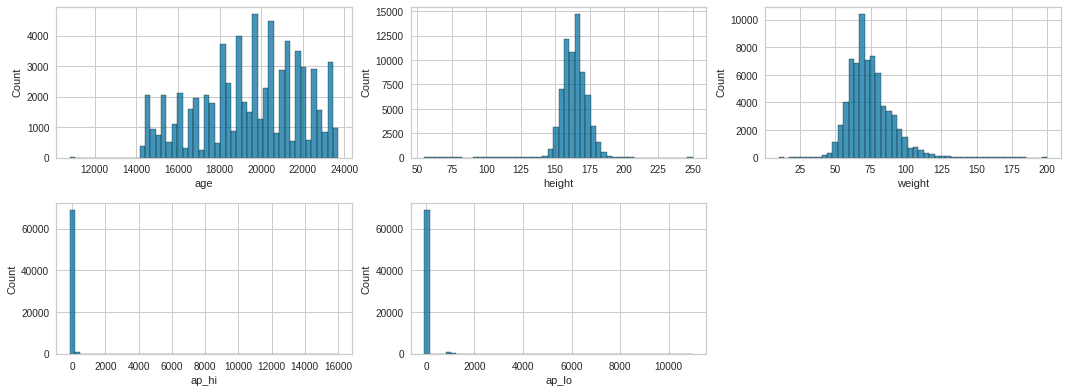

In [95]:
# Checking all numerical vars
numerical_vars = ['age','height', 'weight', 'ap_hi', 'ap_lo']
multi_histogram(data=train, variables=numerical_vars)

### 4.1.1 'cardio' analysis

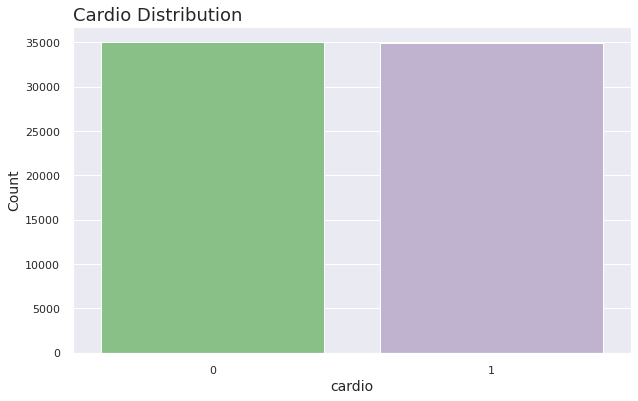

In [102]:
# Target Analysys
balanced_target(target='cardio',dataset=train)

### 4.1.2 'Age'

 - Looks like the count of heart diseases increases with 'Age'.

count    70000.000000
mean        53.339358
std          6.759594
min         29.583562
25%         48.394521
50%         53.980822
75%         58.430137
max         64.967123
Name: age_years, dtype: float64




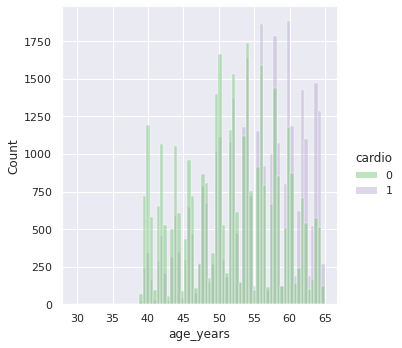

In [9]:
# changing the variable 'Age' to years instead of days
age_df = train.copy()
age_df['age_years'] = age_df['age'] / 365

print(age_df['age_years'].describe())
print('\n')

# Plot distribution
fig = sns.displot(x=age_df['age_years'], hue=age_df['cardio'], data=age_df, kind='hist')

### 4.1.3 'Height'

- The distribution to class 0 and 1 are very similar.
- We found a value of 250 each is impossible to happen in the real world, so we will replace its value for 207 (the highest possible value).
- There are small values like 55cm. Dwarfism is related to a lower expectancy of life usually due to cardiovascular diseases having it in mind we will create a new binary variable 1 - for cases where height is lower than 1,45 and 0 when it's not the case. We will also drop the cases where the Height is less than 112 because these data points are probably an error. The height of dwarf people usually varies between 112 and 145.

count    70000.000000
mean       164.359229
std          8.210126
min         55.000000
25%        159.000000
50%        165.000000
75%        170.000000
max        250.000000
Name: height, dtype: float64




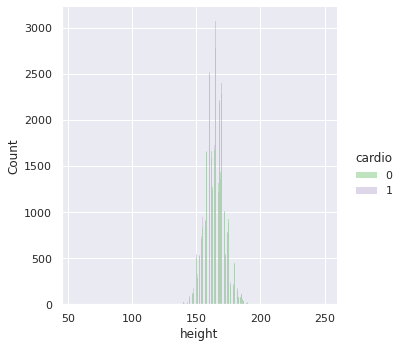

In [10]:
# Describe
print(train['height'].describe())
print('\n')

# Plot distribution
fig = sns.displot(x=train['height'], hue=train['cardio'], data=train, kind='hist')

### 4.1.4 'weight'

- Looks like higher weight leads to more cases of heart disease. 
- Drop the weights bellow 40. Because they are too small and are probably due to some error.

count    70000.000000
mean        74.205690
std         14.395757
min         10.000000
25%         65.000000
50%         72.000000
75%         82.000000
max        200.000000
Name: weight, dtype: float64




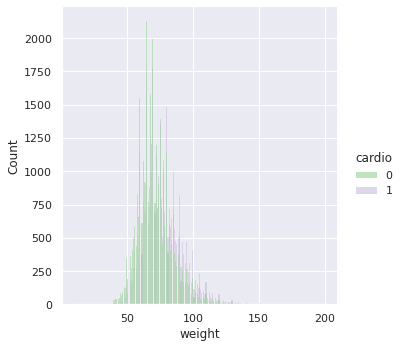

In [11]:
# Describe
print(train['weight'].describe())
print('\n')

# Plot distribution
fig = sns.displot(x=train['weight'], hue=train['cardio'], data=train, kind='hist')

### 4.1.4 'ap_hi'

Researching little be about the subject on the internet unusual readings of Systolic blood pressure below 10 and above 220.
- We have 130 observations below 10 and 624 observations over 220 which is unusual. Let's drop them.

In [36]:
# count below 10 values
train.loc[train['ap_hi']<10,:].size

130

In [9]:
# count values over 220
train.loc[train['ap_hi']>220,:].size

624

count    69942.000000
mean       126.698336
std         17.979907
min         10.000000
25%        120.000000
50%        120.000000
75%        140.000000
max        220.000000
Name: ap_hi, dtype: float64




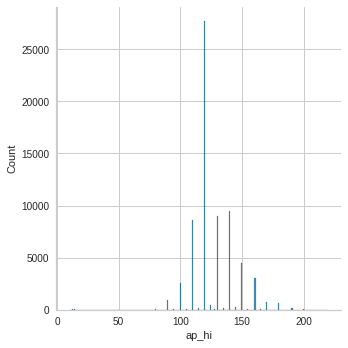

In [38]:
# Dropping
df = train.copy()
index = df.loc[(df['ap_hi']<10)|(df['ap_hi']>220),['ap_hi']].index
df.drop(index, inplace=True)

# Describe
print(df['ap_hi'].describe())
print('\n')

# Plot distribution
fig = sns.displot(x=df['ap_hi'], data=df, kind='hist')

### 4.1.5 'ap_lo'

Researching little be about the subject on the internet unusual readings of Diastolic blood pressure below 5 and divide values over 190 by 10. 

The former is because probably these numbers are type-error. For example, 190.00 blood pressure can be typed as 19000.

- Let's drop the values below 10.
- Let's divide the values over 190 by 10.

count    69024.000000
mean        81.351008
std          9.801631
min          6.000000
25%         80.000000
50%         80.000000
75%         90.000000
max        190.000000
Name: ap_lo, dtype: float64




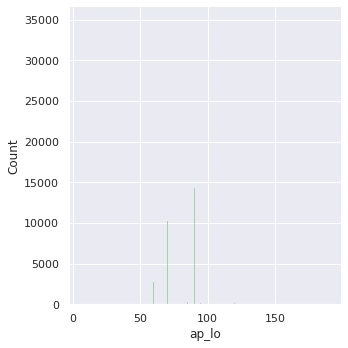

In [14]:
# Dropping
df = train.copy()
index = df.loc[(df['ap_lo']<5)|(df['ap_lo']>190),['ap_lo']].index
df.drop(index, inplace=True)

# Describe
print(df['ap_lo'].describe())
print('\n')

# Plot distribution
fig = sns.displot(x=df['ap_lo'], data=df, kind='hist')

### 4.2 Checking Outliers

We do have a lot of outliers.

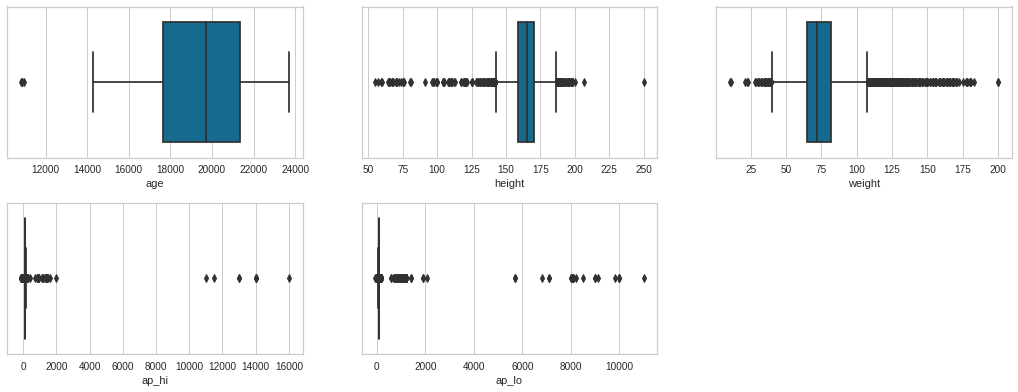

In [85]:
out_train = train.drop(['id','gender','gluc','smoke','cholesterol','active','alco','cardio'],axis=1)
vars = out_train.columns.to_list()

multi_boxplot(data=train, variables=vars)

## 4.2 Bivariate Analysis

- Let's work with just numerical variables.
- By the 'age' vs 'weight' plot we can see that the incidence of event 1 increases as age and weight increase as well.
- The variable 'height' seems to have little influence on our positive event.
- By the 'ap_hi' and 'ap_lo' we can see the presence of some outliers.

In [16]:
# Set of Variables
bi_train = train.drop(['id','gender','gluc','smoke','cholesterol','active','alco'],axis=1)

### 4.2.1 'age' vs 'weight'

<AxesSubplot:xlabel='age', ylabel='weight'>

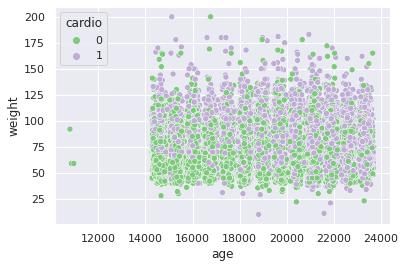

In [17]:
# 'age' vs 'weight'
sns.scatterplot(x='age',y='weight',hue='cardio',data=bi_train)

### 4.2.2 'age' vs 'height'

<AxesSubplot:xlabel='age', ylabel='height'>

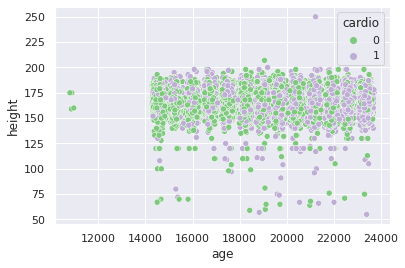

In [18]:
# 'age' vs 'height'
sns.scatterplot(x='age',y='height',hue='cardio',data=bi_train)

### 4.2.3 'age' vs 'ap_lo'

<AxesSubplot:xlabel='age', ylabel='ap_lo'>

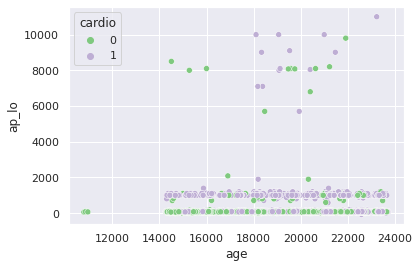

In [19]:
sns.scatterplot(x='age',y='ap_lo',hue='cardio',data=bi_train)

### 4.2.4 'age' vs 'ap_hi'

<AxesSubplot:xlabel='age', ylabel='ap_hi'>

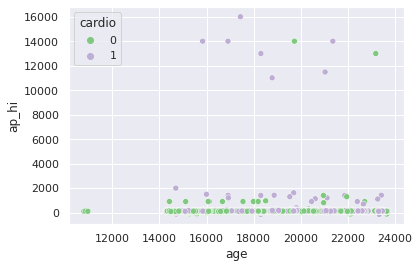

In [20]:
sns.scatterplot(x='age',y='ap_hi',hue='cardio',data=bi_train)

### 4.2.5 cardio vs categoricals

- It seems that our target variable distribution is following the distribution of the categorical variable.
  Ex. 'cholesterol' in our dataset there is a more number of 1-normal that's why there is a concentration of 'cardio' events in this category.

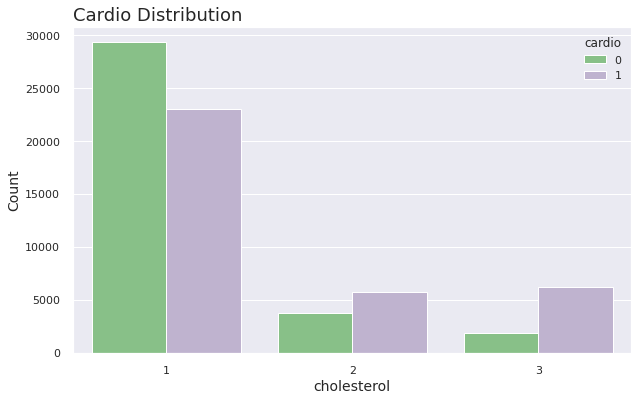

In [97]:
# cardio distribution by 'cholesterol'
balanced_target(target='cholesterol',hue='cardio', dataset=train)

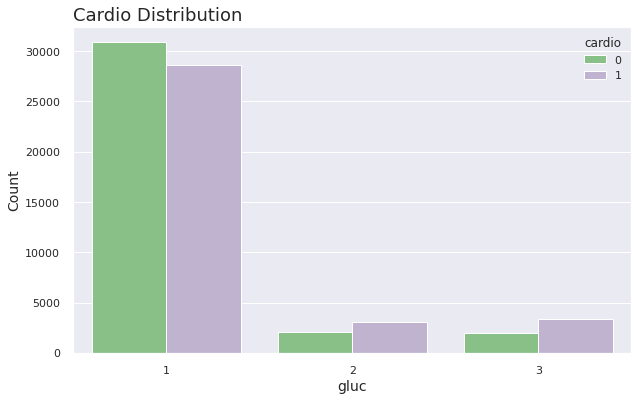

In [98]:
# cardio distribution by 'gluc'
balanced_target(target='gluc',hue='cardio', dataset=train)

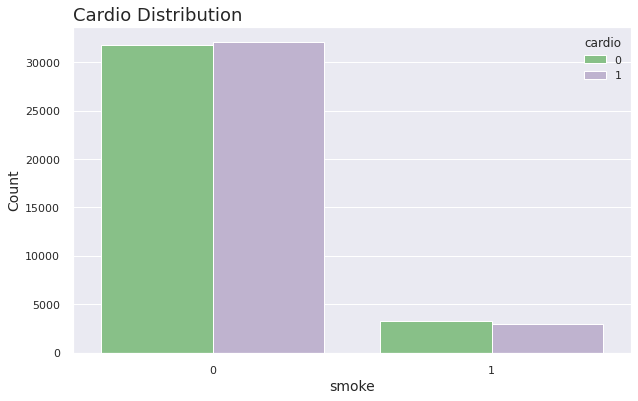

In [99]:
# cardio distribution by 'smoke'
balanced_target(target='smoke',hue='cardio', dataset=train)

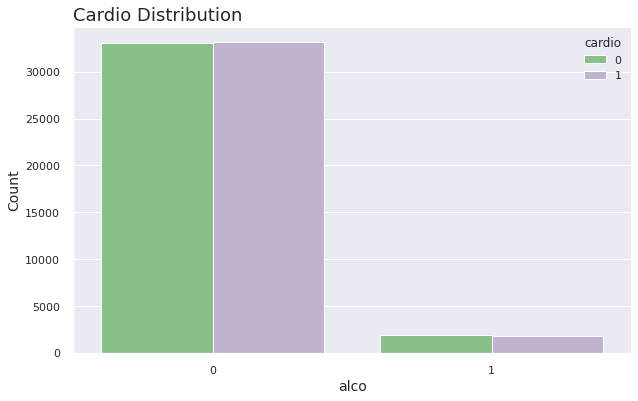

In [100]:
# cardio distribution by 'alco'
balanced_target(target='alco',hue='cardio', dataset=train)

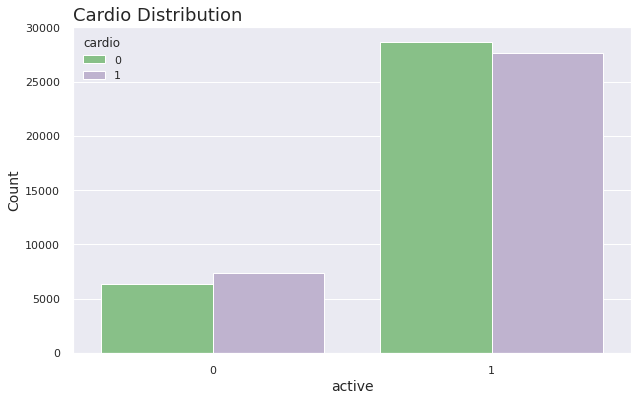

In [101]:
# cardio distribution by 'active'
balanced_target(target='active',hue='cardio', dataset=train)

# 5.0 Hypothesis Test

1.0 Does the 'age' affect the number of cases of cardiovascular disease?

2.0 Does the 'weight' affect the number of cases of cardiovascular disease?

3.0 Does the 'height' affect the number of cases of cardiovascular disease?

#### 5.1 Does the 'age' affect the number of cases of cardiovascular disease?
Conclusion p-value less than 0.05 there is probably a difference since the mean of class 1 is higher the variable 'age' has an impact over the target.

In [52]:
sample_class0 = train.loc[train['cardio']==0,'age']
sample_class1 = train.loc[train['cardio']==1,'age']

print(f'The Mean to class 0: {np.mean(sample_class0)}')
print(f'The Mean to class 1: {np.mean(sample_class1)}')
print('\n')

# Testing the Hypothesis
hipo_test(sample_class0, sample_class1)

The Mean to class 0: 18881.623711487395
The Mean to class 1: 20056.81303067555


O valor de p é: 0.0
Provável haver diferença


(-64.87686765829967, 0.0)

#### 5.2 Does the 'weight' affect the number of cases of cardiovascular disease?
Conclusion p-value less than 0.05 there is probably a difference since the mean of class 1 is higher the variable 'weight' has an impact over the target.

In [53]:
sample_class0 = train.loc[train['cardio']==0,'weight']
sample_class1 = train.loc[train['cardio']==1,'weight']

print(f'The Mean to class 0: {np.mean(sample_class0)}')
print(f'The Mean to class 1: {np.mean(sample_class1)}')
print('\n')

# Testing the Hypothesis
hipo_test(sample_class0, sample_class1)

The Mean to class 0: 71.5921504240313
The Mean to class 1: 76.82236770633808


O valor de p é: 0.0
Provável haver diferença


(-48.8751254371945, 0.0)

#### 5.3 Does the 'height' affect the number of cases of cardiovascular disease?
Conclusion p-value less than 0.05 there is probably a difference since the mean of class 0 is higher the variable 'height' has a little impact on the predictions of class 1.

In [56]:
sample_class0 = train.loc[train['cardio']==0,'height']
sample_class1 = train.loc[train['cardio']==1,'height']

print(f'The Mean to class 0: {np.mean(sample_class0)}')
print(f'The Mean to class 1: {np.mean(sample_class1)}')
print('\n')

# Testing the Hypothesis
hipo_test(sample_class0, sample_class1)

The Mean to class 0: 164.44801690414323
The Mean to class 1: 164.2703336287487


O valor de p é: 0.004196298813631695
Provável haver diferença


(2.863109659842556, 0.004196298813631695)

# 6.0 Pre-Processing / FeatureEngineering

### During the Pre-Processing - Feature Engineering step we perform the actions below
##### obs: The code is in the Helpers Function section of this notebook it was done trough custom transformers

-  We created an age variable in years.
-  We dropped all observations of 'height' with more than 230
-  We dropped al observations of 'height' with less than 112
-  We created the cat_dwarfism variable - if the 'height' is less than 145 it's class 1 otherwise it's 0.
-  We created an 'IMC' variable.
-  We dropped the 'weight' below 40.
-  We dropped the 'ap_hi' values that were less than 10.
-  We dropped the 'ap_hi' values that were less than 5.
-  We divided the 'ap_hi' over 220 by 10 three times. It was necessary due to extremely high values
-  We divided the 'ap_lo' over 190 by 10 two times. It was necessary due to extremely high values
-  We scaled all numerical variables with RobustScaler() due to the presence of outliers, the RobustScaler is not sensitive to extreme values.

# 6.1 Testing Pipeline

- Everything looks fine!!!

In [6]:
tranff = PreProcessingTransformer()
df1 = tranff.fit_transform(dfTrain)
df1.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
3,8,21914,1,151,67.0,120,80,2,2,0,0,0,0
4,9,22113,1,157,93.0,130,80,3,1,0,0,1,0


In [7]:
# Testing the FeatureEng
tranf = FeatureEngineeringTransformer()
df = tranf.fit_transform(dfTrain)
df.head()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,kmeans_cat,year_age,imc,cat_Dwarfism
0,2,168,62.0,110.0,80.0,1,1,0,0,1,0,0,50.391781,21.967120,0
1,1,156,85.0,140.0,90.0,3,1,0,0,1,1,0,55.419178,34.927679,0
2,1,165,64.0,130.0,70.0,3,1,0,0,0,1,0,51.663014,23.507805,0
3,2,169,82.0,150.0,100.0,1,1,0,0,1,1,0,48.282192,28.710479,0
4,1,156,56.0,100.0,60.0,1,1,0,0,0,0,0,47.873973,23.011177,0


In [9]:
pipeline = Pipeline(steps=[('feateng', FeatureEngineeringTransformer()),
                           ('totalpress', TotalPressureTransformer()),
                           ('catpress', CatBloodPressureTransformer())
                           ])

ct = ColumnTransformer([('numerical',MyRobustScalerTransformer(), ['year_age','height','weight', 'ap_hi', 'ap_lo','total_pressure', 'imc']),
                       ('categorical',OneHotEncoder(drop='first'), ['cholesterol', 'gluc', 'active', 'gender', 'smoke', 'alco','cat_bloodpressure','cat_Dwarfism','kmeans_cat'])])


pipeline_final = Pipeline(steps= [('geral',pipeline),
                                  ('num_cat', ct)])

exemp = pipeline_final.fit_transform(dfTrain)
pd.DataFrame(exemp).head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-0.357883,0.272727,-0.588235,-0.5,0.0,-0.5,-0.698518,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.142662,-0.818182,0.764706,1.0,1.0,1.5,1.353997,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.231315,0.000000,-0.470588,0.5,-1.0,0.0,-0.454526,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.567921,0.363636,0.588235,1.5,2.0,2.5,0.369402,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.608565,-0.818182,-0.941176,-1.0,-2.0,-2.0,-0.533175,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# 7.0 Machine Learning Modelling

We choose to deploy the LightGBM model the main reason is that it had the best performance, especially when we use the threshold was 0.60 we achieve a precision of 84% with a global accuracy of 75%, after the tunning of hyperparameters we retrained the model with all the data and deploy it as an API.

**The Algorithms tested was:**

**LogisticRegression:**

**What is Logistic Regression?**

Logistic regression is a transformation of the linear regression model that allows us to probabilistically model binary variables. It is also known as a generalized linear model that uses a logit-link.
Logistic regression is great when we want to model binary data, just like we are doing here, when we want class probability predictions or when we want some interpretability of the model trough its coefficients we can quantify the impact of each feature on your model’s predictions via the odds ratio. On the order hand, Logistic Regression is not that great when our data is not linearly separable.

**How does it work?**

Logistic regression works very much like linear regression.
Input (x) are combined linearly using weights or coefficients values to predict an output (y). The key difference is that the output is modeled as binary values through the equation below

$$
y = e**(b0 + b1*x) / (1 + e**(b0 + b1*x))
$$

The coefficients (Beta values b) of the logistic regression algorithm are estimated by maximum-likelihood estimation.

Maximum-likelihood estimation is a common learning algorithm used by a variety of machine learning algorithms. The best coefficients would result in a model that would predict a value very close to 1 (e.g. male) for the default class and value very close to 0 (e.g. female) for the other class.



**Pros:**
 - Very Simple and easy to understand.
 - Interpretable.
 - Probabilistically outputs.
 - Low cost of maintenance
 

**Cons:**

 - Sensible to highly correlated inputs.
 - Assumes Gaussian Distribution.



**RandomForest:**

**What is Random Forest?**

Random Forest is a set of Decision Trees that are built and can be used for regression or classification tasks (our case). To better understand Random Forest we will quickly understand what Bagging is.

Bagging:
An isolated decision tree has a high variance, however, if we build several Decision Trees based on random samples taken from our dataset and average the predictions for each sample, we considerably reduce the variance of our forecasts. This process is called Bagging.

The formula being:


$$ 
fbag(x) = \frac {1}{b}\sum f^b(x) 
$$


By reducing the variance through the average of several Decision Trees we were able to increase the accuracy of the model.

** How does Random Forest work? **

The difference between Random Forest and Bagging is at the time of each split, in the case of Random Forest, the algorithm randomly chooses m predictors from the total p predictors of the dataset, so the algorithm cannot consider all the predictors for each tree built.

$$ 
m =\sqrt[2]{p} 
$$


What is the reason for this? In order to avoid, as in Bagging, if the dataset has a very strong predictor, all trees will be built equally, using this predictor as the main 'split'.
Random Forests avoid this problem by forcing the algorithm to work with only part of the predictors.

**Pros:**

From decision trees, we can identify more significant movies, as well as the relationship between the variables

Easy to understand, the visualization of the tree is easy to understand, especially when communicating the analysis process to the business areas, since it does not require any statistical knowledge to be read and interpreted.

They do not presuppose the distribution of space or the structure of the classifier, nor are they restricted to data types, being able to manipulate categorical or numerical types.


**Cons:**

Overfitting is one of the biggest difficulties for decision tree models. This problem is solved by defining
restrictions on the model and tunning parameters (pruning).

Not suitable for continuous variables, the decision tree loses information when it categorizes variables in different categories.


**LGBM:**


What is LGBM?

According to the proper documentation of LightGBM, it is a gradient boosting framework that uses tree-based learning algorithms. It is designed to be distributed and efficient with the following advantages:

-    Faster training speed and higher efficiency.

-    Lower memory usage.

-    Better accuracy.

-    Support for parallel and GPU learning.

-    Capable of handling large-scale data.

The main difference of LightGBM compared with other tree-based algorithms is that it grows the tree in a vertical way(leaf-wise) instead of a horizontal way(level-wise). It will choose the leaf with max delta loss to grow and keep growing the same leaf, usually, a Leaf-wise algorithm can reduce more loss than a level-wise algorithm.

The diagrams below may give a more visual comprehension:

Constraints: Usually LightGBM does not work well in small datasets, there is no formal limit here but 10.000 instances would be a good number.

Main Parameters:

max_depth: boosting_type: learning_rate: n_estimators: num_leaves: subsample: min_split_gain: min_split_weight: min_child_samples:


**CatBoost:**

**What is Cat Boost?**

Catboost is a recently open-sourced ML algorithm. It can be integrated with TensorFlow and Apple’s Core ML. The library works well with multiple Categories of data, such as audio, text, image including historical data.

It is especially powerful in two ways:

-    It yields state-of-the-art results without extensive data training typically required by other machine learning methods, and
-    Provides powerful out-of-the-box support for the more descriptive data formats that accompany many business problems.

Its name came from **Cat**egorical data and **Boost**. Since the library is based on gradient boosting machine learning

**Advantages**

-    Performance: CatBoost provides state of the art results and it is competitive with any leading machine learning algorithm on the performance front.

-    Handling Categorical features automatically: We can use CatBoost without any explicit pre-processing to convert categories into numbers. CatBoost converts categorical values into numbers using various statistics on combinations of categorical features and combinations of categorical and numerical features.

-    Robust: It reduces the need for extensive hyper-parameter tuning and lowers the chances of overfitting also which leads to more generalized models. Although, CatBoost has multiple parameters to tune and it contains parameters like the number of trees, learning rate, regularization, tree depth, fold size, bagging temperature, and others.

-    Easy-to-use: You can use CatBoost from the command line, using a user-friendly API.

## 7.1 LogisticRegression Pipeline

In [12]:
# Training Model
def train_LR(X, n_iter, n_splits=10):

    print('> Iniciando Treinamento...')

    cleaning_pipeline = Pipeline(steps=[('preproc', PreProcessingTransformer())])

    pipeline = Pipeline(steps=[('feateng', FeatureEngineeringTransformer()),
                               ('totalpress', TotalPressureTransformer()),
                               ('catpress', CatBloodPressureTransformer())
                               ])

    ct = ColumnTransformer([('numerical',MyRobustScalerTransformer(),  ['year_age', 'height', 'weight', 'ap_hi', 'ap_lo', 'total_pressure', 'imc']),
                           ('categorical',OneHotEncoder(drop='first'), ['cholesterol', 'gluc', 'active', 'gender', 'smoke', 'alco', 'cat_bloodpressure', 'cat_Dwarfism', 'kmeans_cat'])])

    pipeline_final = Pipeline(steps= [('geral',pipeline),
                                      ('num_cat', ct),
                                      ('model', LogisticRegression(C=0.5, n_jobs=-1))])

    data = cleaning_pipeline.fit_transform(X)
    X = data.drop(['cardio'], axis=1)
    y = data['cardio']

    # Fit the random search model
    print('> Fitting Modelo...')

    # cross-validação
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2)

    acc = []
    kappa = []
    recall = []
    for linhas_treino, linhas_valid in skf.split(X, y):

        X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
        y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]


        pipeline_final.fit(X_treino, y_treino)
        pred = pipeline_final.predict(X_valid)
        Acc = accuracy_score(y_valid, pred)
        Kappa =  cohen_kappa_score(y_valid, pred)
        Recall = recall_score(y_valid, pred)
        acc.append(Acc)
        kappa.append(Kappa)
        recall.append(Recall)

    print('####### Bussines Metrics #######')

    print('\n')
    acc_inc = np.mean(acc) - 0.50
    prc_inc = round((acc_inc/0.05)*500, 2)
    print(f'Increased accuracy: {round(acc_inc,2)}')
    print(f'Price Increased in: {prc_inc}')
    print(f'Percentual of Price increassing: {round((prc_inc/500),2)}')
    print('\n')

    print('####### Machine Learning Metrics #######')
    print(f'Accuracy mean: {np.mean(acc)}')
    print(f'Accuracy std: {np.std(acc)}')

    print('\n')

    print(f'kappa mean: {np.mean(kappa)}')
    print(f'kappa std: {np.std(kappa)}')

    print('\n')

    print(f'Recall mean: {np.mean(recall)}')
    print(f'Recall std: {np.std(recall)}')

    print('> Treinamento realizado...')
    return pipeline_final

model_lr = train_LR(X=dfTrain, n_iter=5)

> Iniciando Treinamento...
> Fitting Modelo...
####### Bussines Metrics #######


Increased accuracy: 0.26
Price Increased in: 2565.03
Percentual of Price increassing: 5.13


####### Machine Learning Metrics #######
Accuracy mean: 0.756503053607781
Accuracy std: 0.006621126503799754


kappa mean: 0.5130064168327302
kappa std: 0.013243126699023819


Recall mean: 0.7058133847422696
Recall std: 0.008875655434845985
> Treinamento realizado...


### 7.1.1 Changing the Threshold

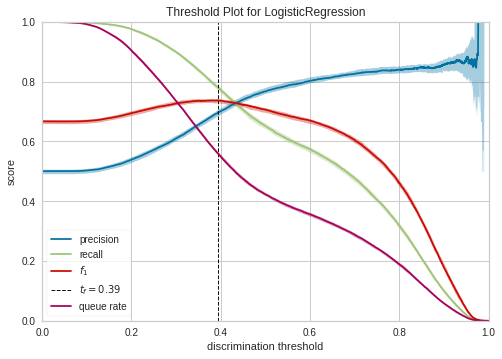

DiscriminationThreshold(ax=<AxesSubplot:title={'center':'Threshold Plot for LogisticRegression'}, xlabel='discrimination threshold', ylabel='score'>,
                        force_model=None, model=None)

In [19]:
# Discrimination_threshold
discrimination_threshold(model_lr, X, y)

In [17]:
# Changing the Threshold - Increasing Precision
new_predictions = change_threshold_lr(X=X, y=y, model=model_lr, n_splits=10, thresh=0.5)

####### Bussines Metrics #######

Increased precision: 0.21
Price Increased in: 2115.0
Percentual of Price increassing: 4.23


####### Machine Learning Metrics #######

New kappa: 0.44524265644955296

              precision    recall  f1-score   support

           0       0.67      0.86      0.76       496
           1       0.81      0.58      0.68       504

    accuracy                           0.72      1000
   macro avg       0.74      0.72      0.72      1000
weighted avg       0.74      0.72      0.72      1000



In [20]:
# Changing the Threshold - Increasing Recall
new_predictions = change_threshold_lr(X=X, y=y, model=model_lr, n_splits=10, thresh=-0.58)

####### Bussines Metrics #######

Increased precision: 0.2
Price Increased in: 2008.0
Percentual of Price increassing: 4.02


####### Machine Learning Metrics #######

New kappa: 0.4171326934478504

              precision    recall  f1-score   support

           0       0.75      0.62      0.68       496
           1       0.68      0.80      0.73       504

    accuracy                           0.71      1000
   macro avg       0.72      0.71      0.71      1000
weighted avg       0.72      0.71      0.71      1000



## 7.2 RandomForest Pipeline

In [21]:
# Training Model
def train_RF(X, n_iter, n_splits=10):

    print('> Iniciando Treinamento...')

    cleaning_pipeline = Pipeline(steps=[('preproc', PreProcessingTransformer())])

    pipeline = Pipeline(steps=[('feateng', FeatureEngineeringTransformer()),
                               ('totalpress', TotalPressureTransformer()),
                               ('catpress', CatBloodPressureTransformer())
                               ])

    ct = ColumnTransformer([('numerical',MyRobustScalerTransformer(), ['year_age', 'height', 'weight', 'ap_hi', 'ap_lo', 'total_pressure', 'imc']),
                           ('categorical',OneHotEncoder(drop='first'), ['cholesterol', 'gluc', 'active', 'gender', 'smoke', 'alco', 'cat_bloodpressure', 'cat_Dwarfism', 'kmeans_cat'])])


    pipeline_final = Pipeline(steps= [('geral',pipeline),
                                      ('num_cat', ct),
                                      ('model', RandomForestClassifier(n_jobs=-1))])


    data = cleaning_pipeline.fit_transform(X)
    X = data.drop(['cardio'], axis=1)
    y = data['cardio']


    # Fit the random search model
    print('> Fitting Modelo...')

    # cross-validação
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

    acc = []
    kappa = []
    recall = []
    for linhas_treino, linhas_valid in skf.split(X, y):

        X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
        y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]


        pipeline_final.fit(X_treino, y_treino)
        pred = pipeline_final.predict(X_valid)
        Acc = accuracy_score(y_valid, pred)
        Kappa =  cohen_kappa_score(y_valid, pred)
        Recall = recall_score(y_valid, pred)
        acc.append(Acc)
        kappa.append(Kappa)
        recall.append(Recall)

    print('####### Bussines Metrics #######')

    print('\n')
    acc_inc = np.mean(acc) - 0.50
    prc_inc = round((acc_inc/0.05)*500, 2)
    print(f'Increased accuracy: {round(acc_inc,2)}')
    print(f'Price Increased in: {prc_inc}')
    print(f'Percentual of Price increassing: {round((prc_inc/500),2)}')
    print('\n')

    print('####### Machine Learning Metrics #######')
    print(f'Accuracy mean: {np.mean(acc)}')
    print(f'Accuracy std: {np.std(acc)}')

    print('\n')

    print(f'kappa mean: {np.mean(kappa)}')
    print(f'kappa std: {np.std(kappa)}')

    print('\n')

    print(f'Recall mean: {np.mean(recall)}')
    print(f'Recall std: {np.std(recall)}')

    print('> Treinamento realizado...')

    return pipeline_final

model_rf = train_RF(X=dfTrain, n_iter=5)

> Iniciando Treinamento...
> Fitting Modelo...
####### Bussines Metrics #######


Increased accuracy: 0.25
Price Increased in: 2502.15
Percentual of Price increassing: 5.0


####### Machine Learning Metrics #######
Accuracy mean: 0.750214883510518
Accuracy std: 0.005327845534533949


kappa mean: 0.5004300464295962
kappa std: 0.010655991302387507


Recall mean: 0.7415520095941518
Recall std: 0.008370898779389607
> Treinamento realizado...


## 7.3 LightGBM Pipeline

In [22]:
# Training LGBM

def train_lightGBM(X, n_iter, n_splits=10):

    print('> Iniciando Treinamento...')

    cleaning_pipeline = Pipeline(steps=[('preproc', PreProcessingTransformer())])

    pipeline = Pipeline(steps=[('feateng', FeatureEngineeringTransformer()),
                               ('totalpress', TotalPressureTransformer()),
                               ('catpress', CatBloodPressureTransformer())
                               ])

    ct = ColumnTransformer([('numerical',MyRobustScalerTransformer(), ['year_age', 'height', 'weight', 'ap_hi', 'ap_lo', 'total_pressure', 'imc']),
                           ('categorical',OneHotEncoder(drop='first'), ['cholesterol', 'gluc', 'active', 'gender', 'smoke', 'alco', 'cat_bloodpressure', 'cat_Dwarfism', 'kmeans_cat'])])

    pipeline_final = Pipeline(steps= [('geral',pipeline),
                                      ('num_cat', ct),
                                      ('feature_selection', VarianceThreshold(threshold=0.1)),
                                      ('model', lgb.LGBMClassifier())])

    data = cleaning_pipeline.fit_transform(X)
    X = data.drop(['cardio'], axis=1)
    y = data['cardio']

    # Fit the model
    print('> Fitting Modelo...')

    # cross-validação
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

    acc = []
    kappa = []
    recall = []
    for linhas_treino, linhas_valid in skf.split(X, y):

        X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
        y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]

        pipeline_final.fit(X_treino, y_treino)
        pred = pipeline_final.predict(X_valid)
        Acc = accuracy_score(y_valid, pred)
        Kappa =  cohen_kappa_score(y_valid, pred)
        Recall = recall_score(y_valid, pred)
        acc.append(Acc)
        kappa.append(Kappa)
        recall.append(Recall)

    print('####### Bussines Metrics #######')

    print('\n')
    acc_inc = np.mean(acc) - 0.50
    prc_inc = round((acc_inc/0.05)*500, 2)
    print(f'Increased accuracy: {round(acc_inc,2)}')
    print(f'Price Increased in: {prc_inc}')
    print(f'Percentual of Price increassing: {round((prc_inc/500),2)}')
    print('\n')

    print('####### Machine Learning Metrics #######')
    print(f'Accuracy mean: {np.mean(acc)}')
    print(f'Accuracy std: {np.std(acc)}')

    print('\n')

    print(f'kappa mean: {np.mean(kappa)}')
    print(f'kappa std: {np.std(kappa)}')

    print('\n')

    print(f'Recall mean: {np.mean(recall)}')
    print(f'Recall std: {np.std(recall)}')

    print('> Treinamento realizado...')

    return pipeline_final

model_lgbm = train_lightGBM(X=dfTrain, n_iter=5)

> Iniciando Treinamento...
> Fitting Modelo...
####### Bussines Metrics #######


Increased accuracy: 0.26
Price Increased in: 2620.22
Percentual of Price increassing: 5.24


####### Machine Learning Metrics #######
Accuracy mean: 0.7620221669305587
Accuracy std: 0.006120145151249876


kappa mean: 0.5240447169998953
kappa std: 0.012241637564766289


Recall mean: 0.7477493036667753
Recall std: 0.008721872335141592
> Treinamento realizado...


### 7.3.1 - Tunning the Hyperparameters

In [53]:
# Tunnig Parameters - GridSearch

from sklearn.model_selection import GridSearchCV

model = pickle.load(open('../models/lgbm_pipe.pkl', 'rb'))


param_grid = {'learning_rate': [0.1, 1, 1.2],
              'n_estimators': [100, 500, 1000, 1500],
              'num_leaves': [10, 31, 50, 70],
              'min_child_samples' : [10, 20, 30, 45]
             }

# Function to tune the parameters
def tunnig_gridsearch(Xtrain, model, param_grid, cv, scoring, refit):

    """
    Função para tunnig de parâmetros utilizando o GridSearchCV

    """


    cleaning_pipeline = Pipeline(steps=[('preproc', PreProcessingTransformer())])

    data = cleaning_pipeline.fit_transform(Xtrain)
    X_ = data.drop(['cardio'], axis=1)
    y_ = data['cardio']


    search = GridSearchCV(estimator=model.named_steps['model'],
                          param_grid=param_grid,
                          scoring=scoring,
                          refit=refit,
                          cv=cv,
                          verbose=1,
                          n_jobs=-1,
                          return_train_score=True)
    search.fit(X_, y_)

    return search.best_params_, search.cv_results_

# Function to retrain with the new parameters and over the all data
def retrain_lightGBM(X,valid, params, n_iter, n_splits=10):

    print('> Iniciando Treinamento...')

    cleaning_pipeline = Pipeline(steps=[('preproc', PreProcessingTransformer())])

    pipeline = Pipeline(steps=[('feateng', FeatureEngineeringTransformer()),
                               ('totalpress', TotalPressureTransformer()),
                               ('catpress', CatBloodPressureTransformer())
                               ])

    ct = ColumnTransformer([('numerical',MyRobustScalerTransformer(), ['year_age', 'height', 'weight', 'ap_hi', 'ap_lo', 'total_pressure', 'imc']),
                           ('categorical',OneHotEncoder(drop='first'), ['cholesterol', 'gluc', 'active', 'gender', 'smoke', 'alco', 'cat_bloodpressure', 'cat_Dwarfism', 'kmeans_cat'])])

    pipeline_final = Pipeline(steps= [('geral',pipeline),
                                      ('num_cat', ct),
                                      ('feature_selection', VarianceThreshold(threshold=0.1)),
                                      ('model', lgb.LGBMClassifier(learning_rate=params['learning_rate'],
                                                                   n_estimators=params['n_estimators'],
                                                                   num_leaves=params['num_leaves'],
                                                                   min_child_samples=params['min_child_samples']
                                                                   ))])

    data = cleaning_pipeline.fit_transform(X)
    X = data.drop(['cardio'], axis=1)
    y = data['cardio']

    # Fit the model
    print('> Fitting Modelo...')

    # cross-validação
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

    acc = []
    kappa = []
    recall = []
    for linhas_treino, linhas_valid in skf.split(X, y):

        X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
        y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]

        pipeline_final.fit(X_treino, y_treino)
        pred = pipeline_final.predict(X_valid)
        Acc = accuracy_score(y_valid, pred)
        Kappa =  cohen_kappa_score(y_valid, pred)
        Recall = recall_score(y_valid, pred)
        acc.append(Acc)
        kappa.append(Kappa)
        recall.append(Recall)

    # modelo treinado somente nas 60000 obs

    Xvalid = valid.drop(['cardio'], axis=1)
    yvalid = valid['cardio']

    tunned_pipe = pipeline_final.fit(Xvalid, yvalid)

    # retrain over all data
    tunned_model = pipeline_final.fit(X, y)
    # Dumping the pipe
    with open('../models/lgbm_pipe_tunning.pkl', 'wb') as f:
         pickle.dump(tunned_model, f)

    print('####### Bussines Metrics #######')

    print('\n')
    acc_inc = np.mean(acc) - 0.50
    prc_inc = round((acc_inc/0.05)*500, 2)
    print(f'Increased accuracy: {round(acc_inc,2)}')
    print(f'Price Increased in: {prc_inc}')
    print(f'Percentual of Price increassing: {round((prc_inc/500),2)}')
    print('\n')

    print('####### Machine Learning Metrics #######')
    print(f'Accuracy mean: {np.mean(acc)}')
    print(f'Accuracy std: {np.std(acc)}')

    print('\n')

    print(f'kappa mean: {np.mean(kappa)}')
    print(f'kappa std: {np.std(kappa)}')

    print('\n')

    print(f'Recall mean: {np.mean(recall)}')
    print(f'Recall std: {np.std(recall)}')

    print('> Treinamento realizado...')

    return tunned_model, tunned_pipe



# Calling the Functions
best_params, cv_results = tunnig_gridsearch(Xtrain=dfTrain,
                                            model=model,
                                            param_grid=param_grid,
                                            scoring='accuracy',
                                            refit='accuracy',
                                            cv=5)

tunned_model, tunned_pipe = retrain_lightGBM(train, dfValid, params=best_params, n_iter=5)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed: 11.0min finished


> Iniciando Treinamento...
> Fitting Modelo...
####### Bussines Metrics #######


Increased accuracy: 0.26
Price Increased in: 2627.51
Percentual of Price increassing: 5.26


####### Machine Learning Metrics #######
Accuracy mean: 0.7627511576919229
Accuracy std: 0.0047260728946104036


kappa mean: 0.5255020204015964
kappa std: 0.009454390392557665


Recall mean: 0.7437742775024327
Recall std: 0.007255773065237008
> Treinamento realizado...


In [54]:
# Best params
best_params

{'learning_rate': 0.1,
 'min_child_samples': 45,
 'n_estimators': 100,
 'num_leaves': 10}

Not a big difference so far!

### 7.3.2 Interpreting the models
With a threshold of 0.40, we can get a new recall of 0.78 with an accuracy of 0.73.

That means that our model will predict class 1 right (positive) with 78% of the timekeeping accuracy of 0.73.

Business-wise it represents an increase of 4.4x in the price reaching R$ 2219.0

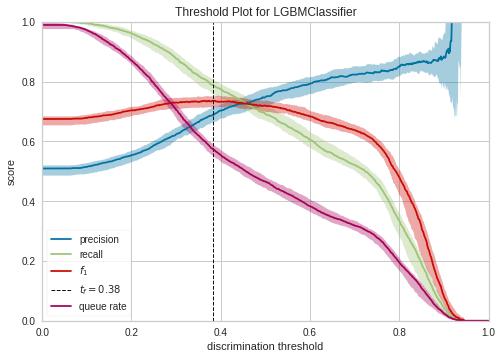

DiscriminationThreshold(ax=<AxesSubplot:title={'center':'Threshold Plot for LGBMClassifier'}, xlabel='discrimination threshold', ylabel='score'>,
                        force_model=None, model=None)

In [45]:
# Discrimination_threshold
discrimination_threshold(tunned_model, X, y)

####### Bussines Metrics #######


Increased precision: 0.22
Price Increased in: 2219.0
Percentual of Price increassing: 4.44


####### Machine Learning Metrics #######

              precision    recall  f1-score   support

           0       0.75      0.68      0.71       496
           1       0.71      0.78      0.74       504

    accuracy                           0.73      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.73      0.73      0.73      1000



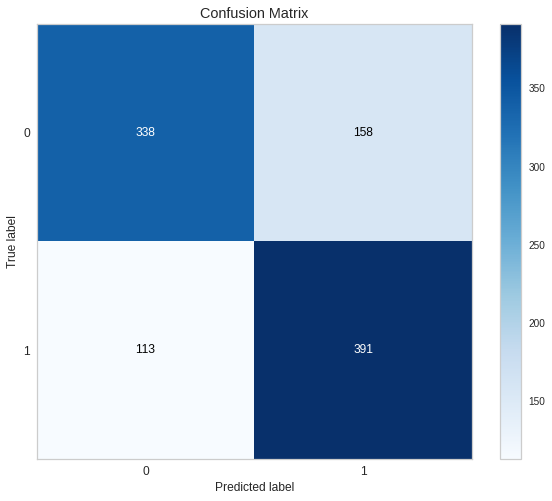

In [64]:
# changing the threshold - Recall
new_pred_prob = change_threshold_lgbm(X=X, y=y, model=tunned_pipe, n_splits=10, thresh=0.40)

####### Bussines Metrics #######


Increased precision: 0.23
Price Increased in: 2316.0
Percentual of Price increassing: 4.63


####### Machine Learning Metrics #######

              precision    recall  f1-score   support

           0       0.71      0.83      0.77       496
           1       0.80      0.67      0.73       504

    accuracy                           0.75      1000
   macro avg       0.76      0.75      0.75      1000
weighted avg       0.76      0.75      0.75      1000



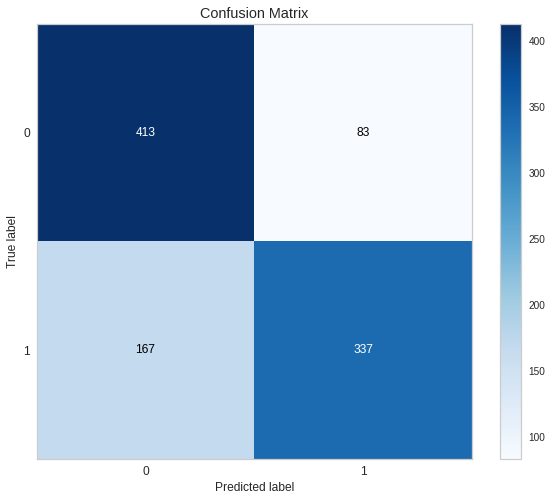

In [56]:
# changing the threshold - Precision
new_pred_prob = change_threshold_lgbm(X=X, y=y, model=tunned_pipe, n_splits=10, thresh=0.6)

## 7.4 CatBoost Pipeline

In [58]:
# CatBoost
def train_catBoost(X, n_iter, n_splits=10):

    print('> Iniciando Treinamento...')
    cleaning_pipeline = Pipeline(steps=[('preproc', PreProcessingTransformer())])

    pipeline = Pipeline(steps=[('feateng', FeatureEngineeringTransformer()),
                               ('totalpress', TotalPressureTransformer()),
                               ('catpress', CatBloodPressureTransformer())
                               ])

    ct = ColumnTransformer([('numerical',MyRobustScalerTransformer(), ['year_age', 'height', 'weight', 'ap_hi', 'ap_lo', 'total_pressure', 'imc']),
                           ('categorical',OneHotEncoder(drop='first'), ['cholesterol', 'gluc', 'active', 'gender', 'smoke', 'alco', 'cat_bloodpressure', 'cat_Dwarfism', 'kmeans_cat'])
                           ])


    pipeline_final = Pipeline(steps= [('geral',pipeline),
                                      ('num_cat', ct),
                                      ('model', CatBoostClassifier(
                                                            n_estimators=100,
                                                            depth=6,
                                                            l2_leaf_reg=0.0,
                                                            bagging_temperature=1,
                                                            early_stopping_rounds=100,
                                                            loss_function='Logloss',
                                                            eval_metric='Accuracy',
                                                            verbose=False))])

    data = cleaning_pipeline.fit_transform(X)
    X = data.drop(['cardio'], axis=1)
    y = data['cardio']

    # Fit the random search model
    print('> Fitting Modelo...')

    # cross-validação
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

    acc = []
    kappa = []
    recall = []
    for linhas_treino, linhas_valid in skf.split(X, y):

        X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
        y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]

        pipeline_final.fit(X_treino, y_treino)
        pred = pipeline_final.predict(X_valid)
        Acc = accuracy_score(y_valid, pred)
        Kappa =  cohen_kappa_score(y_valid, pred)
        Recall = recall_score(y_valid, pred)
        acc.append(Acc)
        kappa.append(Kappa)
        recall.append(Recall)

    print('####### Bussines Metrics #######')

    print('\n')
    acc_inc = np.mean(acc) - 0.50
    prc_inc = round((acc_inc/0.05)*500, 2)
    print(f'Increased accuracy: {round(acc_inc,2)}')
    print(f'Price Increased in: {prc_inc}')
    print(f'Percentual of Price increassing: {round((prc_inc/500),2)}')
    print('\n')

    print('####### Machine Learning Metrics #######')
    print(f'Accuracy mean: {np.mean(acc)}')
    print(f'Accuracy std: {np.std(acc)}')

    print('\n')

    print(f'kappa mean: {np.mean(kappa)}')
    print(f'kappa std: {np.std(kappa)}')

    print('\n')

    print(f'Recall mean: {np.mean(recall)}')
    print(f'Recall std: {np.std(recall)}')

    print('> Treinamento realizado...')

    return pipeline_final

model_cat = train_catBoost(X=train, n_iter=5)

> Iniciando Treinamento...
> Fitting Modelo...
####### Bussines Metrics #######


Increased accuracy: 0.26
Price Increased in: 2614.11
Percentual of Price increassing: 5.23


####### Machine Learning Metrics #######
Accuracy mean: 0.7614109181209591
Accuracy std: 0.005678371061547817


kappa mean: 0.5228215061980126
kappa std: 0.011359869822032615


Recall mean: 0.7335187423148588
Recall std: 0.00761050773815609
> Treinamento realizado...


### 7.4.1 Interpreting the Model

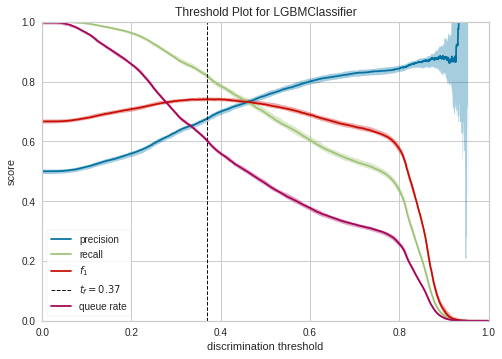

DiscriminationThreshold(ax=<AxesSubplot:title={'center':'Threshold Plot for LGBMClassifier'}, xlabel='discrimination threshold', ylabel='score'>,
                        force_model=None, model=None)

In [70]:
# Discrimination_threshold
discrimination_threshold(model_lgbm, X, y)

####### Bussines Metrics #######


Increased precision: 0.2
Price Increased in: 2040.0
Percentual of Price increassing: 4.08


####### Machine Learning Metrics #######

              precision    recall  f1-score   support

           0       0.76      0.60      0.67       496
           1       0.67      0.81      0.74       504

    accuracy                           0.71      1000
   macro avg       0.72      0.71      0.70      1000
weighted avg       0.71      0.71      0.70      1000



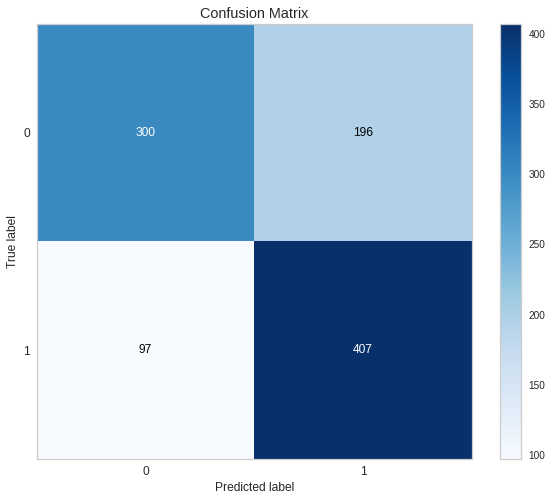

In [61]:
# changing the threshold - Recall
new_pred_prob = change_threshold_lgbm(X=X, y=y, model=model_cat , n_splits=10, thresh=0.35)

####### Bussines Metrics #######


Increased precision: 0.23
Price Increased in: 2288.0
Percentual of Price increassing: 4.58


####### Machine Learning Metrics #######

              precision    recall  f1-score   support

           0       0.70      0.85      0.77       496
           1       0.81      0.64      0.71       504

    accuracy                           0.74      1000
   macro avg       0.75      0.74      0.74      1000
weighted avg       0.76      0.74      0.74      1000



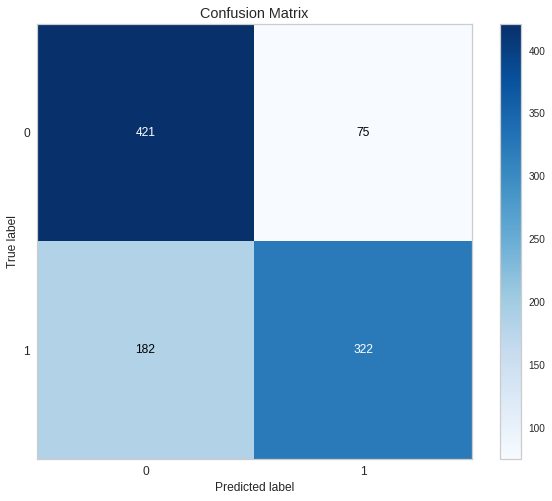

In [60]:
# changing the threshold - Precission
new_pred_prob = change_threshold_lgbm(X=X, y=y, model=model_cat , n_splits=10, thresh=0.6)

In [75]:
def train_catBoost_stats(X, y):

    print('> Iniciando Treinamento...')

    # Transfomer para os dados de Teste
    transfomer = Pipeline(steps=[('feateng', FeatureEngineeringTransformer()),
                                 ('totalpress', TotalPressureTransformer()),
                                 ('catpress', CatBloodPressureTransformer()),
                                 ('scaler', MyRobustScalerTransformer())])

    # Transformando os dados de Teste
    xtreino = transfomer.fit_transform(X)

    # Criando Modelo
    model = CatBoostClassifier(early_stopping_rounds=100,
                               loss_function='Logloss',
                               eval_metric='Accuracy',
                               verbose=False)

    # Fit the random search model
    print('> Fitting Modelo...')
    model.fit(xtreino, y)

    print('> Treinamento realizado...')

    res = model.calc_feature_statistics(xtreino, y,
                                        feature=1,
                                        plot=True)

model_cat = train_catBoost_stats(X=Xtrain, y=ytrain)

> Iniciando Treinamento...
> Fitting Modelo...
> Treinamento realizado...


In [77]:
# Processo de Treinamento
def train_catBoost_viz(X, y, evalX, evaly):

    print('> Iniciando Treinamento...')

    # Transfomer para os dados de Teste
    transfomer = Pipeline(steps=[('feateng', FeatureEngineeringTransformer()),
                                 ('totalpress', TotalPressureTransformer()),
                                 ('catpress', CatBloodPressureTransformer()),
                                 ('scaler', MyRobustScalerTransformer())])




    # Criando o Pipeline de Treino
    pipeline = Pipeline(steps=[('feateng', FeatureEngineeringTransformer()),
                               ('totalpress', TotalPressureTransformer()),
                               ('catpress', CatBloodPressureTransformer()),
                               ('scaler', MyRobustScalerTransformer()),
                               ('model', CatBoostClassifier(early_stopping_rounds=100,
                                                            loss_function='Logloss',
                                                            eval_metric='Recall',
                                                            verbose=False))])


    # Transformando os dados de Teste
    xteste = transfomer.fit_transform(evalX)


    # Fit the random search model
    print('> Fitting Modelo...')
    pipeline.fit(X, y, model__plot=True, model__eval_set=(xteste, evaly))

    print('> Treinamento realizado...')
    return pipeline

model_cat = train_catBoost_viz(X=Xtrain, y=ytrain, evalX=Xtest, evaly=ytest)

> Iniciando Treinamento...
> Fitting Modelo...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

> Treinamento realizado...


# 8.0 API_Predictions

In our example the prediction was class 0, therefore no heart diseases in this case.

In [60]:
# Example Data
test_data = train.sample()

# Tunnig into a json
df_json = test_data.to_json(orient='records')
df_json

'[{"id":34477,"age":20609,"gender":2,"height":160,"weight":60.0,"ap_hi":140,"ap_lo":90,"cholesterol":1,"gluc":1,"smoke":0,"alco":0,"active":1,"cardio":1}]'

### 8.1 API_Predictions - Normal Threshold

In [61]:
# url = 'http://0.0.0.0:5000/predict'
url = 'https://pa001-app.herokuapp.com/predict'
data = df_json
header = {'Content-type': 'application/json'}

# Request
r = requests.post(url=url, data=data, headers=header)
print(r.status_code)
r.json()

200


[{'id': 34477,
  'age': 20609,
  'gender': 2,
  'height': 160,
  'weight': 60.0,
  'ap_hi': 140,
  'ap_lo': 90,
  'cholesterol': 1,
  'gluc': 1,
  'smoke': 0,
  'alco': 0,
  'active': 1,
  'cardio': 1,
  'prediction': 0}]

### 8.2 API_Predictions - Impossing Threshold (0.6)

In [62]:
# url = 'http://0.0.0.0:5000/predict_thresh'
url = 'https://pa001-app.herokuapp.com/predict_thresh'
data = df_json
header = {'Content-type': 'application/json'}

# Request
r = requests.post(url=url, data=data, headers=header)
print(r.status_code)
r.json()

200


[{'id': 34477,
  'age': 20609,
  'gender': 2,
  'height': 160,
  'weight': 60.0,
  'ap_hi': 140,
  'ap_lo': 90,
  'cholesterol': 1,
  'gluc': 1,
  'smoke': 0,
  'alco': 0,
  'active': 1,
  'cardio': 1,
  'prediction': 0.0}]